# *Imports*

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pandas as pd
import scipy

from skimage import data, color

random.seed(26)
np.random.seed(26)

----------------

# **Part 1 of the homework**

## Visualizing dyad


I take the image data.cofee from `skimage.data`. For simplicity I tranformed it in grayscale so that the image is represented as the matrix $X \in \mathbb{R}^{m \times n}$. 
* Load the image into memory and compute its SVD;
* Visualization of some of the dyad $\sigma_i u_i v_i^T$ of this decomposition. 
* Plot the singular values of $X$.

Image dimensions:  400 x 600
U: (400, 400), S: (400,), Vt: (600, 600)
Rank of the matrix image =  400


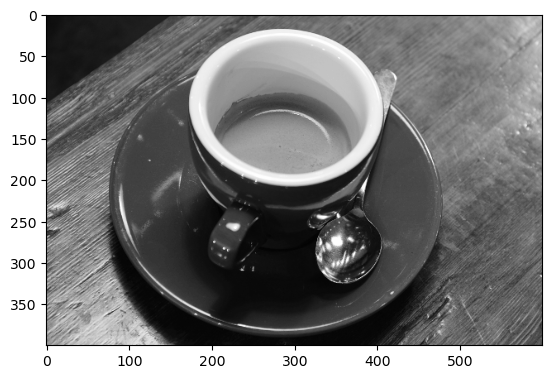

In [35]:
# Load and convert to grayscale
image = color.rgb2gray(data.coffee()) 
m, n = image.shape
print("Image dimensions: ", m,"x" ,n)

# Compute the SVD of the image
U, S, Vt = np.linalg.svd(image, full_matrices=True) # if full_matrices=True, then U and Vt are not truncated
print(f"U: {U.shape}, S: {S.shape}, Vt: {Vt.shape}")
print("Rank of the matrix image = ",S.size)

plt.imshow(image, cmap='gray')
plt.show()


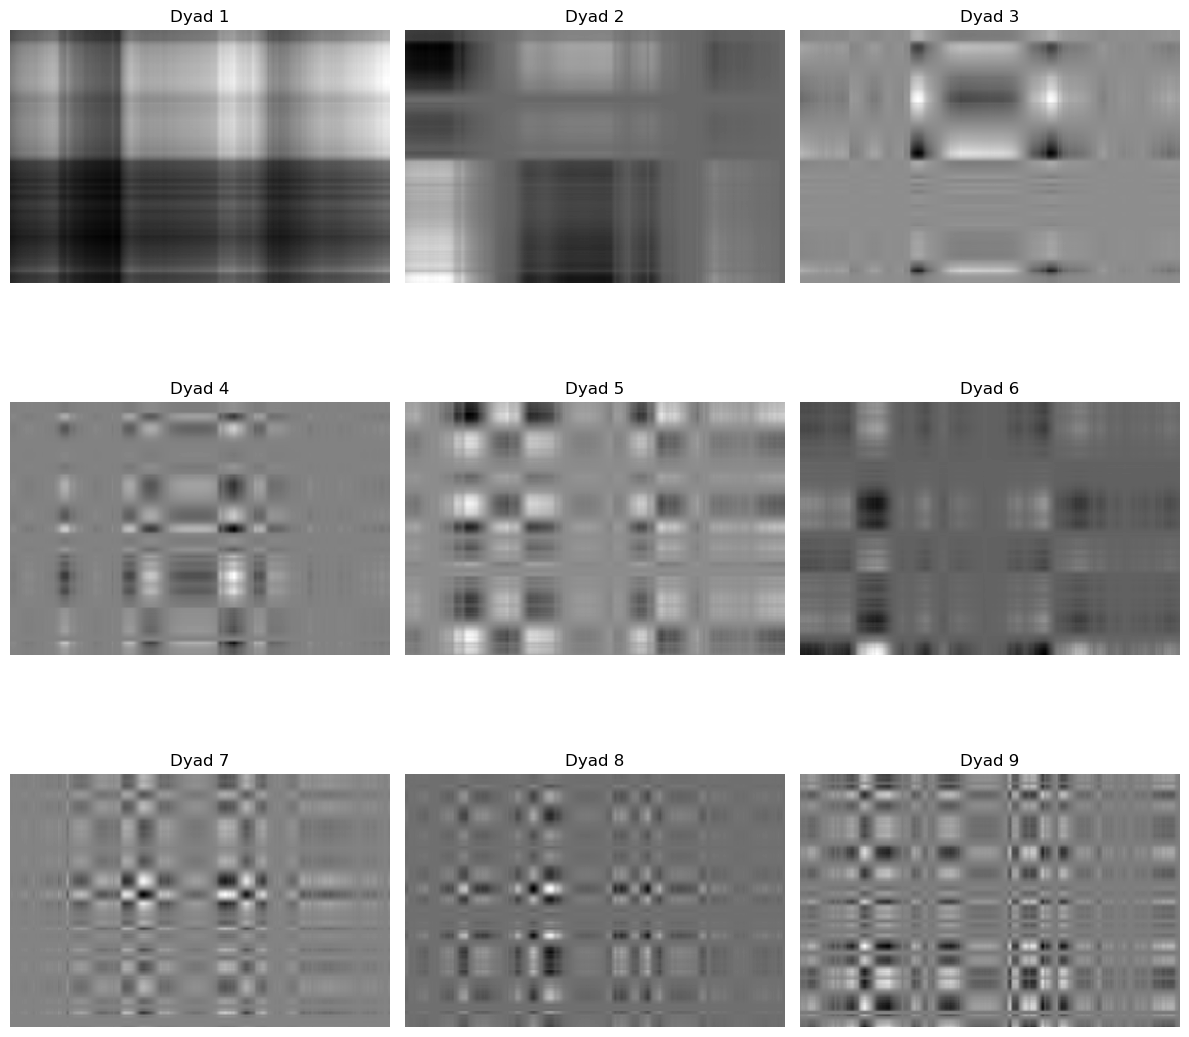

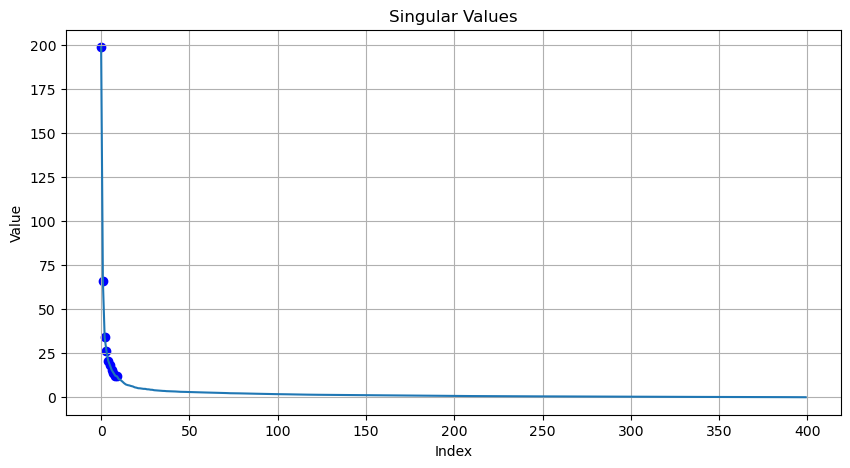

In [36]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Plot the dyads
for i, k in enumerate(k_values):
    dyad = np.outer(U[:, k - 1], Vt[k - 1, :])
    ax = axes[i // 3, i % 3]
    ax.imshow(dyad, cmap="gray")
    ax.set_title(f"Dyad {k}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Plot the singular values
plt.figure(figsize=(10, 5))
plt.plot(S)
plt.scatter(range(0,10),S[0:10],  color='blue', marker='o')
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid()
plt.show()

##  SVD Decomposition

As we remeber a given matrix $A \in \mathbb{R}^{m \times n}$  it's always possible to decompose it in the following form:

$$ A = U \Sigma V^T $$

where:
- $U \in \mathbb{R}^{m×m}$ is an orthogonal matrix with columns $u_i$ called left-singular vectors.
- $V \in \mathbb{R}^{n×n}$ is an orthogonal matrix with columns $v_i$ called right-singular vectors.
- $\Sigma \in \mathbb{R}^{m×n}$ is a matrix with $\Sigma_{i,j} = 0$ for each $i \neq j$ and the singular values $\sigma_i, i = 1 \dots \min\{m, n\}$ on the diagonal   

As we can see from the `print()` the *dimensions of the decomposed matrix of the image match the rule.*  
We can also notice how the first dyads, formed by the first singular values, are those that contain more information. This is due to the fact that the *singular values ​​give the importance of the dyad*, the greater the value, the more important the information contained in the dyad will be.   
Almost all the information is contained in the first $100$ singular values. 
The next `plot` is the proof.

* Visualization of the $k$-rank approximation of $X$ for different values of $k$.

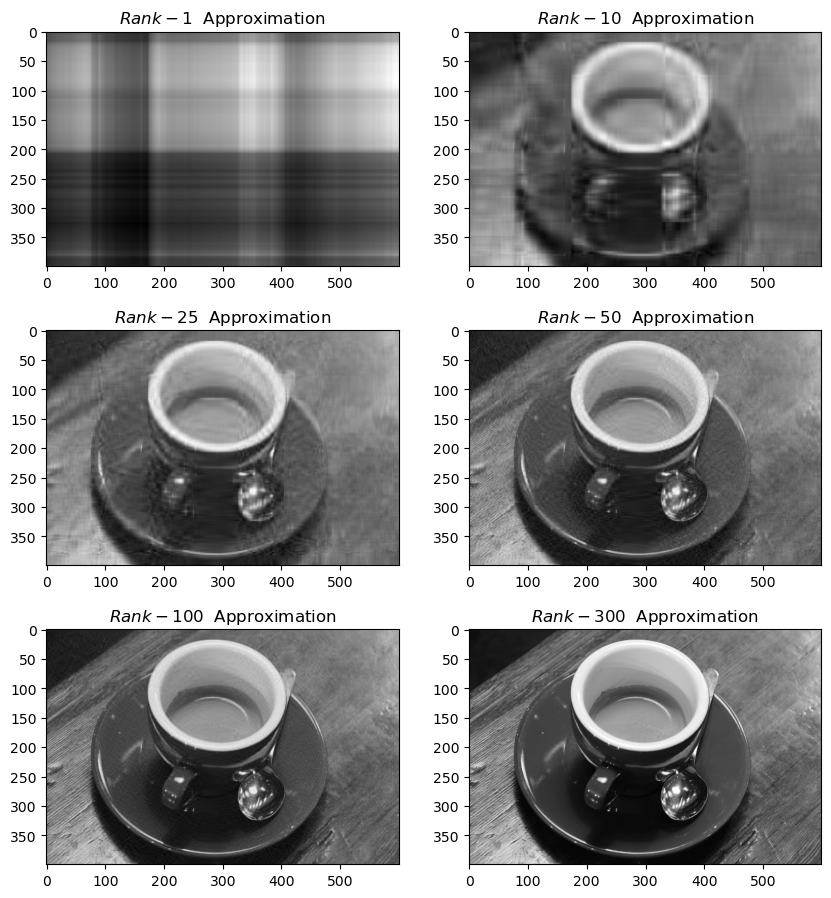

In [37]:
k_values = [1, 10, 25, 50, 100, 300]
plt.figure(figsize=(10, 11))
for i, k in enumerate(k_values):
    X_k = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    plt.subplot(3, 2, i + 1)
    plt.imshow(X_k, cmap="gray")
    plt.title(f"$Rank-{k}$  Approximation")
plt.show()

* Compute and plot the approximation error $|| X − X_k ||_F$ for increasing values of $k$, where $X_k$ is the $k$-rank approximation of $k$.
* Plot the compression factor $c_k = 1 − \frac{k(m+n+1)}{mn}$ for increasing values of $k$.
* Compute the value $k$ such that $c_k = 0$, finding the point, and its approximation error, in which the compressed image requires the same amount of informations of those of the uncompressed image. 

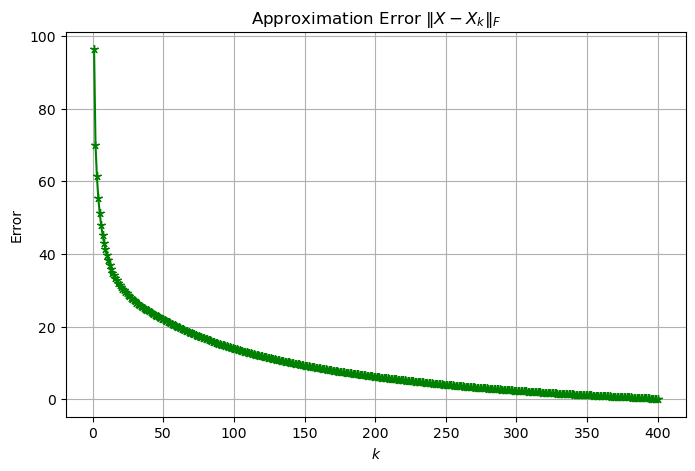

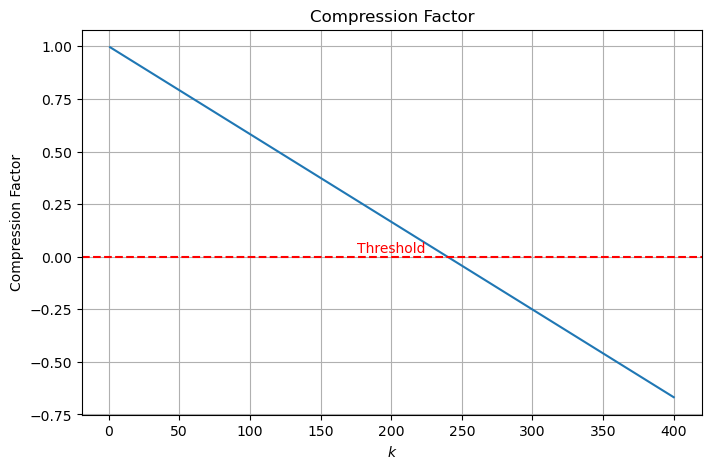

For k(239) with compression factor 0, the error is = 4.36


In [38]:
# Plot the approximation error
errors = []
for k in range(1, min(m, n) + 1):
    # Compute the approximation of the image of rank k
    X_k = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    error = np.linalg.norm(image - X_k, ord="fro")
    errors.append(error)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(errors) + 1), errors, color = 'g',marker=(5, 2))
plt.title(r"Approximation Error $\|X - X_k\|_F$")
plt.xlabel(r"$k$")
plt.ylabel("Error")
plt.grid()
plt.show()

# Plot the compression factor
compression_factors = [1 - (k * (m + n + 1)) / (m * n) for k in range(1, min(m, n) + 1)]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(compression_factors) + 1), compression_factors)
plt.axhline(y=0, color='r', linestyle='--', label='Threshold')
plt.text(len(compression_factors) / 2, 0.02, 'Threshold', color='red', ha='center')
plt.title("Compression Factor")
plt.xlabel(r"$k$")
plt.ylabel("Compression Factor")
plt.grid()
plt.show()

# Print the error for k with compression factor 0 
k = np.argmin(np.array(compression_factors) > 0)
print(f"For k({k}) with compression factor 0, the error is = {errors[k]:.2f}")


Using a compression factor k greater than 239 is worse than not compressing the image at all. This is rare and would indicate that the compression has increased the data size, which is not desirable.  
We can also observe that the plot of the approximation error  $||X − X_k||_2$ compared with the plot of $\sigma_k$ are similar. This can be proven by:

$$   \|X − X_k\|_2  = \|  \sum_{i=1}^{r}\sigma_i X_i - \sum_{j=1}^{k} \sigma_j X_j  \|_2 = \| \sum_{i=k+1}^{r} \sigma_i X_i \|_2 = \max(\sigma_i) = \sigma_{k+1}$$

----------------

# **Part 2 of the homework**

## Classification of MNIST Digits with SVD Decomposition  

The aim of the exercise is to develop a classification algorithm on MNIST digits using SVD decomposition.  
Given a matrix $X \in \mathbb{R}^{d \times N}$ and its SVD decomposition $X = USV^T$, where $p = rank(X)$ is equal to the number of non-zero singular values($\sigma_i) of $X$ and consequently to the number of columns of the matrix $U$.  
We will make use of the space of this columns (that are orthogonal) and the following Theorem:

**Theorem 1.** Let $W$ be a subspace of $\mathbb{R}^d$ with $dim W = s$, and let ${w_1, \dots, w_s}$ be an orthogonal basis of $W$. Then, for any $x \in \mathbb{R}^d$, the projection $x^\perp$ of $x$ onto $W$ has the following form:

$$
x^\perp = \frac{x \cdot w_1}{w_1 \cdot w_1} w_1 + \dots + \frac{x \cdot w_s}{w_s \cdot w_s} w_s.
$$

**Corollary 1.1.** Let $X \in \mathbb{R}^{d \times N}$ be a matrix with SVD decomposition $X = USV^T$, since $p = rank(X)$ is the dimension of the space defined by the columns of $X$ and the columns of $U$, ${u_1, \dots, u_p}$ are an orthonormal basis for that space, the projection of an $d$-dimensional vector $x$ on this space can be easily
computed as:

$$
x^\perp = U(U^T x).
$$



*Consider as an example* a binary classification problem, where we want to distinguish between hand-written digit representing numbers `3` and `4`.  
We will refer to the class of the images representing number `3` as $C_1$, and to the set of images representing the number `4` as $C_2$.  
Let $N_1$ be the number of elements in $C_1$, and $N_2$ be the number of elements in $C_2$. Let $X_1 \in \mathbb{R}^{d \times N_1}$ be the matrix such that its columns are a flatten version of each digit in $C_1$, $X_2 \in \mathbb{R}^{d \times N_2}$ be the matrix such that its columns are a flatten version of each digit in $C_2$, and consider:

$$
X_1 = U_1S_1V_1^T, \\
X_2 = U_2S_2V_2^T,
$$

the SVD decomposition of the two matrices.

If $x \in \mathbb{R}^{d}$ is a new, unknown digit, we can predict its class through our classification algorithm by projecting it onto the spaces induced by the SVD of $X_1$ and $X_2$ via:

$$
x_1^\perp = U_1(U_1^T x), \\
x_2^\perp = U_2(U_2^T x),
$$

and classify $x$ as an element of either $C_1$ or $C_2$ based on $||x − x_1^\perp ||_2$ being greater of lower than $||x−x_2^\perp ||_2$, respectively.


In [39]:
# Project a vector x_test onto the subspace spanned by the columns of U
def project_onto_U(U, x_test):
    return U @ (U.T @ x_test)

Given a classification algorithm $f(x)$, which maps an input image $x$ into its predicted class, the misclassification rate on the test set is defined as:

$$
MR = \frac{1}{N_{test}} \sum_{i=1}^{N_test} \iota(f(x_i) == y_i),
$$

In [40]:
# Define the tax rate of misclassification of the test set
def misclassification_rate(list_of_U, labels, X_test, Y_test):
    N_test = X_test.shape[1]
    misclassifications = 0
    
    for i in range(N_test):
        z = X_test[:, i]
        true_label = Y_test[i]
        predicted_label = labels[classify_digit(list_of_U, z)-1]
        
        if predicted_label != true_label:
            misclassifications += 1
    
    MR = misclassifications / N_test
    return MR

## Preparation data and Classification

In [41]:
# filtering the dataset based on the label
def filter_dataset(X, Y, label):
    idx = np.zeros(Y.shape, dtype=bool)
    for i in range(len(label)):
        idx += Y == label[i]
    X_filtered = X[:, idx]
    Y_filtered = Y[idx]
    print(f"Shape of the original dataset: {X.shape} {Y.shape}")
    print(f"Shape of the filtered dataset: {X_filtered.shape} {Y_filtered.shape}")
    return X_filtered, Y_filtered

# split the data into training and testing sets
def split_data(X, Y, per_train=0.8):
    N_train = int(X.shape[1] * per_train)

    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[:, train_idx]
    Y_train = Y[train_idx]
    
    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    print(f"Train test split = {Y_train.size}, {Y_test.size}")

    return (X_train, Y_train), (X_test, Y_test)

def split_in_classes(X, Y, labels):
    classes = []
    for label in labels:
        classes.append(X[:, Y == label])
    print(f"Number of classes: {len(classes)}")
    return classes

# Classify a digit x_test as C1 or C2 based on the distances from the subspaces U1 and U2
def classify_digit(list_of_U, x_test, see = False):
    distances = []
    for i, U in enumerate(list_of_U):
        # Project x_test onto U
        x_proj = project_onto_U(U, x_test)
        # Distans x_test - x_proj
        d = np.linalg.norm(x_test - x_proj, 2)
        distances.append(d)
        if see:
            print(f"Distanza da U{i + 1}: {d}")
    
    # Return the index of the subspace with the smallest distance
    return np.argmin(distances) + 1

# confusion matrix
def confusion_matrix(list_of_U, labels, X_test, Y_test):
    N_test = X_test.shape[1]
    C = len(labels)
    conf_matrix = np.zeros((C, C))
    
    for i in range(N_test):
        z = X_test[:, i]
        true_label = Y_test[i]
        predicted_label = labels[classify_digit(list_of_U, z)-1]
        
        conf_matrix[true_label, predicted_label] += 1
    
    return conf_matrix

# Visualization of the confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Aggiunta dei valori arrotondati a un decimale
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f"{int(conf_matrix[i, j])}", ha='center', va='center', color='black')

    plt.show()


## Implementation of the classification algorithm

* Download the MNIST dataset from and load it into memory. When loaded the dataset appear as an array with shape $42000 \times 785$ , containining the flattened version of $42000$ $28 \times 28$ grayscale handwritten digits, plus a column representing the true class of the corresponding digit.
* Pre-processing the data obtaining a matrix `X` containing the flattenened digits, with shape `(784, 42000)`, and a vector `Y` of the associated digit value, with a shape of `(42000,)`.
* Function taking as input an index value `idx` and visualizes the image of `X` in the corresponding index (i.e. `X[idx, :]`). 


In [42]:
ds = pd.read_csv("train.csv")
# Inspect the data
print(f"Shape of the data: {ds.shape}")
print("")
# Convert data into a matrix
data = np.array(ds)

X = data[:, 1:]
X = X.T
Y = data[:, 0]

print(X.shape, Y.shape)
ds.head()

Shape of the data: (42000, 785)

(784, 42000) (42000,)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


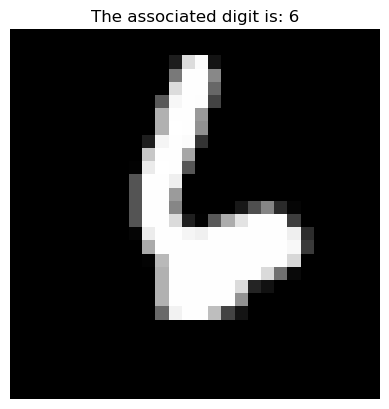

In [43]:
# Visualize the image of index 'idx' from the dataset 'X'

# Funzione per visualizzare l'immagine di indice 'idx' dal dataset 'X'
def visualize(X, Y, idx):
    img = X[:, idx]
    img = np.reshape(img, (28, 28))  # Reshape it
    plt.imshow(img, cmap='gray')
    plt.title(f"The associated digit is: {Y[idx]}")
    plt.axis('off')  # Nasconde gli assi per una visualizzazione più pulita
    plt.show()

# Visualize image
idx = 26
visualize(X, Y, idx)

* Filter from `X` only those elements that corresponds to digits 3 or 4. 
* Split the obtained dataset in training and testing in a proportion of $80 : 20$.
* Call `X1` and `X2` the submatrices of the training set, filtered by the two selected digits, corresponding to those element associated with number `3`, and with number `4` and compute the SVD decomposition.

In [44]:
# Filtering the digits 3 and 4
labels = [3, 4]
X_3_4, Y_3_4 = filter_dataset(X, Y, labels)
d, N = X_3_4.shape
print(f"Number of samples: {N}")

# Train Test split
(X_3_4_train, Y_3_4_train), (X_3_4_test, Y_3_4_test) = split_data(X_3_4, Y_3_4, 0.80)

# Split the data into classes
classes = split_in_classes(X_3_4_train, Y_3_4_train, labels)
X1, X2 = classes
print(f"Number of samples in class 1: {X1.shape[1]}")
print(f"Number of samples in class 2: {X2.shape[1]}")

# Decomposition SVD
U1, S1, Vt1 = np.linalg.svd(X1, full_matrices=True)
U2, S2, Vt2 = np.linalg.svd(X2, full_matrices=True)
print(f"Dimension of U1: {U1.shape}")
print(f"Dimension of U2: {U2.shape}")
list_of_U = [U1, U2]



Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 8423) (8423,)
Number of samples: 8423
Train test split = 6738, 1685
Number of classes: 2
Number of samples in class 1: 3494
Number of samples in class 2: 3244
Dimension of U1: (784, 784)
Dimension of U2: (784, 784)


* Compute, for three unknown digits $x$ from the test set. 
$$x_1^\perp = U_1(U_1^T x)$$
$$x_2^\perp = U_2(U_2^T x)$$
* Compute the distances $d_1 = || x − x_1^\perp ||_2$ and $d_2 = || x − x_2^\perp||_2$
* Classification of $x$ as $X_1$ if $d_1 < d_2$, as $X_2$ if $d_2 < d_1$.

Distanza da U1: 5.51878840869191e-12
Distanza da U2: 5.0575148477861205e-12
La cifra è classificata dal modello come: 4


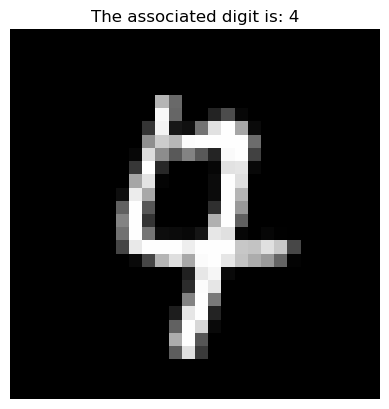

Distanza da U1: 6.551138793552632e-12
Distanza da U2: 7.673659545509373e-12
La cifra è classificata dal modello come: 3


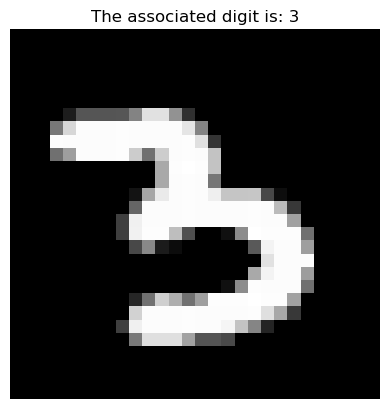

Distanza da U1: 4.425076983274706e-12
Distanza da U2: 5.600581847412726e-12
La cifra è classificata dal modello come: 3


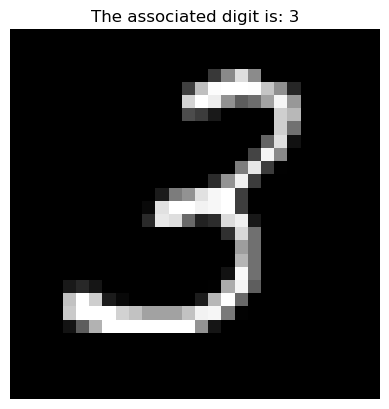

In [45]:
random = [random.randint(0, X_3_4_test.shape[1]) for i in range(3)]
for i in random:
    z = X_3_4_test[:, i]
    classe = classify_digit(list_of_U, z, see=True)
    print(f"La cifra è classificata dal modello come: {labels[classe-1]}")
    visualize(X_3_4_test, Y_3_4_test, i)

*  Compute the misclassification rate for this algorithm.

In [46]:
MR_3_4 = misclassification_rate(list_of_U, labels, X_3_4_test, Y_3_4_test)
print(f"Misclassification rate: {MR_3_4:.4f}")

Misclassification rate: 0.0641


* Repeating the experiment for different digits other than 3 or 4.

In [47]:
# Extract digits
labels = [8, 9]
X_8_9, Y_8_9 = filter_dataset(X, Y, labels)
d, N = X_8_9.shape
print(f"Number of samples: {N}")

# Train Test split
(X_8_9_train, Y_8_9_train), (X_8_9_test, Y_8_9_test) = split_data(X_8_9, Y_8_9, 0.80)

# Split the data into classes
classes = split_in_classes(X_8_9_train, Y_8_9_train, labels)
X1, X2 = classes
print(X1[1].shape + X2[1].shape)

# Decomposition SVD
U1, S1, Vt1 = np.linalg.svd(X1, full_matrices=True)
U2, S2, Vt2 = np.linalg.svd(X2, full_matrices=True)
print(f"Dimension of U1: {U1.shape}")
print(f"Dimension of U2: {U2.shape}")
list_of_U = [U1, U2]

MR_8_9 = misclassification_rate(list_of_U, labels, X_8_9_test, Y_8_9_test)
print(f"Misclassification rate: {MR_8_9:.4f}")

Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 8251) (8251,)
Number of samples: 8251
Train test split = 6600, 1651
Number of classes: 2
(3277, 3323)
Dimension of U1: (784, 784)
Dimension of U2: (784, 784)
Misclassification rate: 0.1811


In [48]:
# Extract digits
labels = [0, 1]
X_0_1, Y_0_1 = filter_dataset(X, Y, labels)
d, N = X_0_1.shape
print(f"Number of samples: {N}")

# Train Test split
(X_0_1_train, Y_0_1_train), (X_0_1_test, Y_0_1_test) = split_data(X_0_1, Y_0_1, 0.80)

# Split the data into classes
classes = split_in_classes(X_0_1_train, Y_0_1_train, labels)
X1, X2 = classes
print(X1[1].shape + X2[1].shape)

# Decomposition SVD
U1, S1, Vt1 = np.linalg.svd(X1, full_matrices=True)
U2, S2, Vt2 = np.linalg.svd(X2, full_matrices=True)
print(f"Dimension of U1: {U1.shape}")
print(f"Dimension of U2: {U2.shape}")
list_of_U = [U1, U2]

MR_0_1 = misclassification_rate(list_of_U, labels, X_0_1_test, Y_0_1_test)
print(f"Misclassification rate: {MR_0_1:.4f}")

Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 8816) (8816,)
Number of samples: 8816
Train test split = 7052, 1764
Number of classes: 2
(3312, 3740)
Dimension of U1: (784, 784)
Dimension of U2: (784, 784)
Misclassification rate: 0.0023


In [49]:
MR_0_1_train = misclassification_rate(list_of_U, labels, X_0_1_train, Y_0_1_train)
MR_3_4_train = misclassification_rate(list_of_U, labels, X_3_4_train, Y_3_4_train)
MR_8_9_train = misclassification_rate(list_of_U, labels, X_8_9_train, Y_8_9_train)

print(f"Misclassification rate of the train 0 and 1: {MR_0_1_train:.4f}")
print(f"Misclassification rate of the train 3 and 4: {MR_3_4_train:.4f}")
print(f"Misclassification rate of the train 8 and 9: {MR_8_9_train:.4f}")
print()
print(f"Misclassification rate for 0 and 1: {MR_0_1:.4f}")
print(f"Misclassification rate for 3 and 4: {MR_3_4:.4f}")
print(f"Misclassification rate for 8 and 9: {MR_8_9:.4f}")

Misclassification rate of the train 0 and 1: 0.0021
Misclassification rate of the train 3 and 4: 1.0000
Misclassification rate of the train 8 and 9: 1.0000

Misclassification rate for 0 and 1: 0.0023
Misclassification rate for 3 and 4: 0.0641
Misclassification rate for 8 and 9: 0.1811


we can notice how pairs of similar numbers tend to have a higher error, this is because the different classes have images that share the same information (bits).  
The test set MR and the train set MR are pretty similar, so in this particular case, we don't see overfitting or underfitting.

In [50]:
# Extract digits
labels = [0, 8, 9]
X_0_8_9, Y_0_8_9 = filter_dataset(X, Y, labels)
d, N = X_0_8_9.shape
print(f"Number of samples: {N}")

# Train Test split
(X_0_8_9_train, Y_0_8_9_train), (X_0_8_9_test, Y_0_8_9_test) = split_data(X_0_8_9, Y_0_8_9, 0.80)

# Split the data into classes
classes = split_in_classes(X_0_8_9_train, Y_0_8_9_train, labels)
X1, X2, X3 = classes
print(X1[1].shape + X2[1].shape+ X3[1].shape)

# Decomposition SVD
U1, S1, Vt1 = np.linalg.svd(X1, full_matrices=True)
U2, S2, Vt2 = np.linalg.svd(X2, full_matrices=True)
U3, S3, Vt3 = np.linalg.svd(X3, full_matrices=True)
print(f"Dimension of U1: {U1.shape}")
print(f"Dimension of U2: {U2.shape}")
print(f"Dimension of U3: {U3.shape}")
list_of_U = [U1, U2, U3]

MR_0_8_9 = misclassification_rate(list_of_U, labels, X_0_8_9_test, Y_0_8_9_test)
print(f"Misclassification rate: {MR_0_8_9:.4f}")

Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 12383) (12383,)
Number of samples: 12383
Train test split = 9906, 2477
Number of classes: 3
(3277, 3254, 3375)
Dimension of U1: (784, 784)
Dimension of U2: (784, 784)
Dimension of U3: (784, 784)
Misclassification rate: 0.2325


In [51]:
# Extract digits
labels = [0, 1, 7]
X_0_1_7, Y_0_1_7 = filter_dataset(X, Y, labels)
d, N = X_0_1_7.shape
print(f"Number of samples: {N}")

# Train Test split
(X_0_1_7_train, Y_0_1_7_train), (X_0_1_7_test, Y_0_1_7_test) = split_data(X_0_1_7, Y_0_1_7, 0.80)

# Split the data into classes
classes = split_in_classes(X_0_1_7_train, Y_0_1_7_train, labels)
X1, X2, X3 = classes
print(X1[1].shape + X2[1].shape+ X3[1].shape)

# Decomposition SVD
U1, S1, Vt1 = np.linalg.svd(X1, full_matrices=True)
U2, S2, Vt2 = np.linalg.svd(X2, full_matrices=True)
U3, S3, Vt3 = np.linalg.svd(X3, full_matrices=True)
print(f"Dimension of U1: {U1.shape}")
print(f"Dimension of U2: {U2.shape}")
print(f"Dimension of U3: {U3.shape}")
list_of_U = [U1, U2, U3]

MR_0_1_7 = misclassification_rate(list_of_U, labels, X_0_1_7_test, Y_0_1_7_test)
print(f"Misclassification rate: {MR_0_1_7:.4f}")

Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 13217) (13217,)
Number of samples: 13217
Train test split = 10573, 2644
Number of classes: 3
(3305, 3792, 3476)
Dimension of U1: (784, 784)
Dimension of U2: (784, 784)
Dimension of U3: (784, 784)
Misclassification rate: 0.0200


In [52]:
print(f"Misclassification rate for 0, 1 and 7: {MR_0_1_7:.4f}")
print(f"Misclassification rate for 0, 8 and 9: {MR_0_8_9:.4f}")

Misclassification rate for 0, 1 and 7: 0.0200
Misclassification rate for 0, 8 and 9: 0.2325


same conclusion of before

#### Test fatto con tutte le classi

In [53]:
# Extract digits
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
X_0_1_2_3_4_5_6_7_8_9, Y_0_1_2_3_4_5_6_7_8_9 = filter_dataset(X, Y, labels)
d, N = X_0_1_2_3_4_5_6_7_8_9.shape
print(f"Number of samples: {N}")

# Train Test split
(X_0_1_2_3_4_5_6_7_8_9_train, Y_0_1_2_3_4_5_6_7_8_9_train), (X_0_1_2_3_4_5_6_7_8_9_test, Y_0_1_2_3_4_5_6_7_8_9_test) = split_data(X_0_1_2_3_4_5_6_7_8_9, Y_0_1_2_3_4_5_6_7_8_9, 0.80)

# Split the data into classes
classes = split_in_classes(X_0_1_2_3_4_5_6_7_8_9_train, Y_0_1_2_3_4_5_6_7_8_9_train, labels)
list_of_U = []
for X in classes:
    U, S, Vt = np.linalg.svd(X, full_matrices=True)
    list_of_U.append(U)

MR_0_1_2_3_4_5_6_7_8_9 = misclassification_rate(list_of_U, labels, X_0_1_2_3_4_5_6_7_8_9_test, Y_0_1_2_3_4_5_6_7_8_9_test)


Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 42000) (42000,)
Number of samples: 42000
Train test split = 33600, 8400
Number of classes: 10


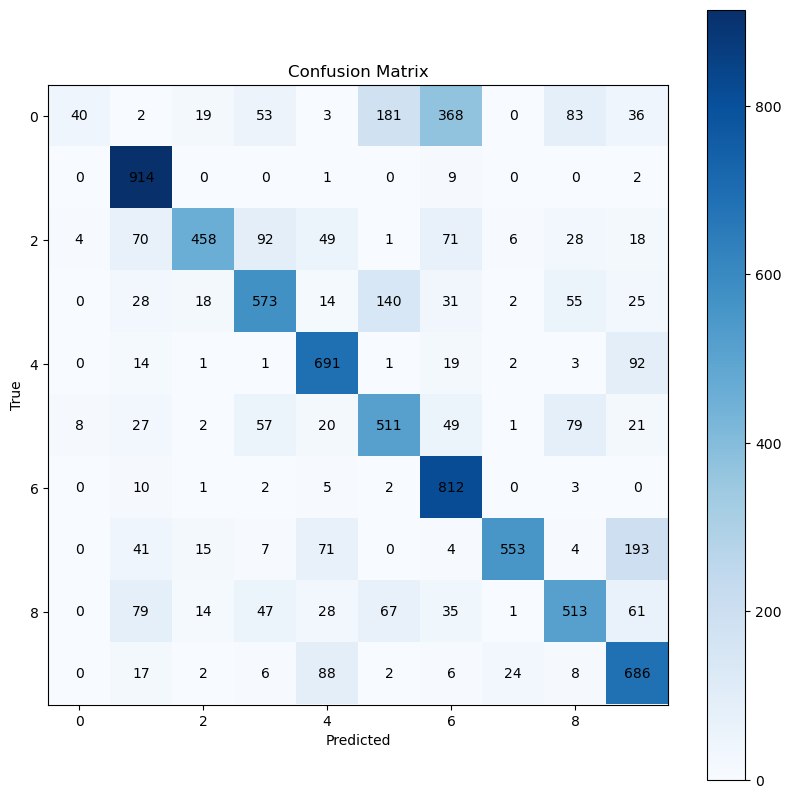

Misclassification rate: 0.3154


In [54]:
conf_matrix = confusion_matrix(list_of_U, labels, X_0_1_2_3_4_5_6_7_8_9_test, Y_0_1_2_3_4_5_6_7_8_9_test)
plot_confusion_matrix(conf_matrix)
print(f"Misclassification rate: {MR_0_1_2_3_4_5_6_7_8_9:.4f}")


Quite a good result. It has an `accuracy` of 69%

----------------

# **Part 3 of the homework**

## Clustering with PCA
Principal Component Analysis (PCA) is based on the idea of dimensionality reduction techniques in ML is to find a projector operator $P: \mathbb{R}^d \to \mathbb{R}^k$, with $k \ll d$, such that in the projected space $P(x)$, images which are semantically similar are close to each other.  

So we want to find a matrix $P \in \mathbb{R}^{k \times d}$ such that $Z = PX$, with the constraint that in the projected space we want to keep as much information as possible from the original dataset $X$. 
$Z$ is define as the projected version of $X$:
$$
    Z = [z^1 z^2 \dots z^N] \in \mathbb{R}^{k \times N}
$$
For keeping informations, we use the Truncated Singular Value Decomposition(TSVD) of $X$ to create $P$:
$$
    X_k = U_k \Sigma_k V^T_k
$$
The PCA uses this idea and defines the projection matrix as $P = U_k^T$, and consequently:
$$
    Z = U_k^T X
$$

The columns of $U_k$ are called **feature vectors**, while the columns of $Z$ are the **principal components** of $X$.

If the points in a projected space form isolated populations such that _inside_ of each popoulation the points are close, while the distance _between_ populations is large, we call them **clusters**.

PCA is an unsupervised algorithm, thus it does not require any label.

To implement PCA, we first need to _center_ the data.  
This can be done by defining its centroid.  
Given a set $X = [x^1 x^2 \dots x^N]$, its **centroid** is defined as $ c(X) = \frac{1}{N} \sum_{i=1}^N x^i$.

## General functions

In [93]:
def PCA(X_train, Y_train, labels, d = 784, k=2):
    """
    Compute the PCA.
    
    Parameters:
    X_train (numpy.ndarray): Train set.
    Y_train (numpy.ndarray): Train set.
    labels list(int): List of labels.
    d (int): Dimension of the data.
    k (int): Dimension of the low-dimensional space.
    
    Returns:
    Z_train numpy.ndarray: Train set projected into the low-dimensional space.
    list_centroid_clusters_projections list(numpy.ndarray): List of centroids of the clusters projected into the low-dimensional space.
    tuple: Tuple containing the centroid of the data and the projection matrix.
    """
    # Compute centroid
    cX_train = np.mean(X_train, axis=1)

    # Make it a column vector
    cX_train = np.reshape(cX_train, (d, 1))

    # Center the data
    Xc = X_train - cX_train

    # Compute SVD decomposition
    U, s, VT = np.linalg.svd(Xc, full_matrices=False) #  to save computation time

    # Compute reduced SVD
    Uk = U[:, :k]

    # Define projection matrix
    P = Uk.T

    # Project X_train centred -> Z_train
    Z_train = P @ Xc

    # Project centroid clusters
    list_centroid_clusters_projections = []
    for label in labels:
        Zn = Z_train[:, Y_train == label]
        cX = np.mean(Zn, axis=1)
        list_centroid_clusters_projections.append(cX)
    return Z_train, list_centroid_clusters_projections, (cX_train,P) 

def average_distance_of_clusters_from_centroid(Z, Y_train, centroids):
    """
    Compute the average distance of each data of the cluster from its centroid.
    
    Returns:
    dict: Average distance of each cluster from its centroid.
    """
    distances = {}
    labels = np.unique(Y_train)
    
    for i,label in enumerate(labels):
        cluster = Z[:, Y_train == label]
        centroid = centroids[i]
        for data in cluster.T:
            distance = np.linalg.norm(data.ravel() - centroid.ravel())
            average_distance = round(np.mean(distance),3)
            distances[label] = average_distance
    
    return distances

def project_test_set(X_test, train_coefficients):
    """
    Project the test set X_test into the low-dimensional space using the projection matrix P.
    
    Parameters:
    X_test (numpy.ndarray): Test set.
    train_coefficients tuple: Tuple containing the centroid of the train data and the projection matrix.
    
    Returns:
    numpy.ndarray: Test set projected into the low-dimensional space.
    """
    cx = train_coefficients[0]
    P = train_coefficients[1]

    Xc_test = X_test - cx
    Z_test = P @ Xc_test
    return Z_test

def classify_based_on_centroid(x, centroids, labels):
    """
    Classify a new observation x based on the distance to cluster centroids.
    
    Parameters:
    x (numpy.ndarray): New observation.
    centroids (list): List of coordinates of the cluster centroids.
    
    Returns:
    int: The class corresponding to the closest centroid.
    """
    distances = [np.linalg.norm(x.ravel() - centroid.ravel()) for centroid in centroids]
    return labels[np.argmin(distances)]

def predict(X_test, centroids, labels):
    """
    Predict the labels of the test set.
    
    Parameters:
    X_test (numpy.ndarray): Test set.
    centroids (list): List of coordinates of the cluster centroids.
    labels (list): List of labels.
    
    Returns:
    numpy.ndarray: Predicted labels.
    """
    N_test = X_test.shape[1]
    Y_pred = np.zeros(N_test)
    
    for i in range(N_test):
        x = X_test[:, i]
        Y_pred[i] = classify_based_on_centroid(x, centroids, labels)
    
    return np.array(Y_pred)

def evaluation_PCA(X_test, Y_test, centroids, labels):
    """
    Compute the misclassification rate of the classification algorithm on the test set.
    
    Parameters:
    X_test (numpy.ndarray): Test set.
    Y_test (numpy.ndarray): True labels of the test set.
    centroids (list): List of coordinates of the cluster centroids.
    labels (list): List of labels.
    
    Returns:
    float: Misclassification rate.
    float: Accuracy.
    """
    misclassifications = 0
    N_test = X_test.shape[1]
    Y_pred = predict(X_test, centroids, labels)
    
    return np.mean(Y_test!=Y_pred), np.mean(Y_test==Y_pred)

# Visualize the clusters
def visualize_2D(Z, Y, list_centroid_clusters_projections):
    labels = np.unique(Y)
    ax = plt.scatter(Z[0, :], Z[1, :], c=Y)
    plt.legend(*ax.legend_elements(), title="Digit") # Add to the legend the list of digits
    for i, Z_centroid in enumerate(list_centroid_clusters_projections):
        plt.scatter(Z_centroid[0], Z_centroid[1], c='red', marker='v')
        plt.text(Z_centroid[0], Z_centroid[1], f'Centroid {labels[i]}', fontsize=10, color='red', ha='right')   
    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_2$")
    plt.title("PCA projection of MNIST digits 0-9")
    plt.grid()
    plt.show()

def visualize_3D(Z, Y, list_centroid_clusters_projections):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Identify the clasters
    labels = np.unique(Y)
    for i,label in enumerate(labels):
        cluster = Z[:, Y == label]
        ax.scatter(cluster[0, :], cluster[1, :], cluster[2, :], label=f'Digit {label}', alpha=0.1)
        
        # Calculate the centroid
        centroid = list_centroid_clusters_projections[i]
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='v', s=200, c='red') 
        ax.text(centroid[0], centroid[1], centroid[2], f'Centroid {label}', fontsize=12, color='red', ha='right')

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend()
    plt.title('PCA Projection and Cluster Centroids in 3D')
    plt.show()

* Load and pre-process the dataset to get the matrix `X` with shape `(784, 42000)`, and the associated vector `Y`.
* Choose a number of digits (`0`, `6` and `9`) and extract from `X` and `Y` the sub-dataset containing only the considered digits.
* Creating `X_train` and `Y_train`.

In [94]:
ds = pd.read_csv("train.csv")
# Inspect the data
print(f"Shape of the data: {ds.shape}")
print("")
# Convert data into a matrix
data = np.array(ds)

X = data[:, 1:]
X = X.T
Y = data[:, 0]
print(X.shape, Y.shape)
ds.head()

Shape of the data: (42000, 785)

(784, 42000) (42000,)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
# Extract digits
labels = [0, 6, 9]
X_0_6_9, Y_0_6_9 = filter_dataset(X, Y, labels)
d, N = X_0_6_9.shape
print(f"Number of samples: {N}")

# Train Test split
(X_0_6_9_train, Y_0_6_9_train), (X_0_6_9_test, Y_0_6_9_test) = split_data(X_0_6_9, Y_0_6_9, 0.8 )


Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 12457) (12457,)
Number of samples: 12457
Train test split = 9965, 2492


* Implementation of the algorithms computing the PCA of `X_train` with a fixed value of $k$. 
* Visualization of the results (for $k = 2$) and the position of the centroid of each cluster.
* Compute, for each cluster, the average distance from its centroid.
* Projection of the test set `X_test` on the low-dimensional space.
* For each cluster in the test set, compute the average distance to the corresponding centroid (from the train set).
* Compute the misclassification rate (**MR**) of this algorithm on the test set.

The **clusters** are identified by projecting `X_train` via PCA to its low-dimension version `Z_train`, and then splitting it into sets (say, `Z1`, `Z2`, `Z3`) based on `Y_train`.  
Each set `Z1`, `Z2`, `Z3` represents a cluster, of which we can easily compute the centroid.

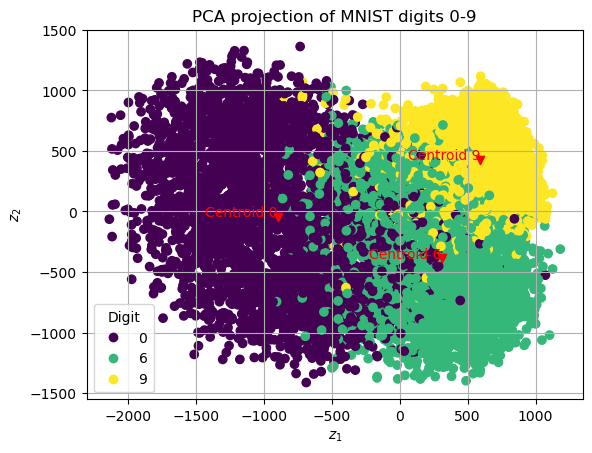

cluster0 coordinate = [-897.18371654  -43.64805974]
cluster1 coordinate = [ 309.26740167 -387.07865154]
cluster2 coordinate = [591.38633948 428.83955319]
Average distance of each data of the cluster from its centroid: {0: 824.386, 6: 652.509, 9: 440.135}
Projection of test into the low-dimensional space: (2, 2492)
Mean distance from test clusters and the realtive train centroid: {0: 1367.231, 6: 64.849, 9: 187.148}
Misclassification rate: 0.1565, Accuracy: 0.8435


In [86]:
# PCA
Z_0_6_9_train_k2, proj_centr_clust_k2, train_coefficients = PCA(X_0_6_9_train, Y_0_6_9_train, labels, d, 2)

visualize_2D(Z_0_6_9_train_k2, Y_0_6_9_train, proj_centr_clust_k2)

# Print coordinates of the centroids
for i, coord in enumerate(proj_centr_clust_k2):
    print(f"cluster{i} coordinate = {coord}")

# Compute the average distance of each cluster from its centroid
distances_train_0_6_9_k2 = average_distance_of_clusters_from_centroid(Z_0_6_9_train_k2, Y_0_6_9_train, proj_centr_clust_k2)
print(f"Average distance of each data of the cluster from its centroid: {distances_train_0_6_9_k2}")

# Project the test set into the low-dimensional space
Z_0_6_9_test_k2 = project_test_set(X_0_6_9_test, train_coefficients)
print("Projection of test into the low-dimensional space:", Z_0_6_9_test_k2.shape)

# Compute the average distance of each cluster of X_test from the train centroid
distances_test_0_6_9_k2 = average_distance_of_clusters_from_centroid(Z_0_6_9_test_k2, Y_0_6_9_test, proj_centr_clust_k2)
print("Mean distance from test clusters and the realtive train centroid:", distances_test_0_6_9_k2)

# Misclassification rate of the test set
MR_0_6_9_k2, acc_0_6_9_k2 = evaluation_PCA(Z_0_6_9_test_k2, Y_0_6_9_test, proj_centr_clust_k2, labels)
print(f"Misclassification rate: {MR_0_6_9_k2:.4f}, Accuracy: {acc_0_6_9_k2:.4f}")

Even though there are only $3$ classes to consider, the clusters are not well divided among themselves.  
This is due to $k=2$ being too low, and PCA being too simple to be able to capture the total complexity of the data.

However, the model appear to be quite good, showing that the algorithm is performing well. `Acc =` $0.85$

The *average distance* of each data of the cluster *from its centroid* evaluates the compactness or cohesion, of clusters projected into the two-dimensional space.  
It reflects how concentrated the data points are around the center. A *lower* average distance indicates that the data points are *tightly grouped* near the centroid, suggesting a more compact cluster.  
In this case, cluster $9$ exhibits the lowest average distance making it the most compact cluster, while cluster $0$ shows the highest average distance of indicating greater dispersion.

Additionally a low *average distance between test clusters* and the corresponding *train centroids* suggests that the test data aligns well with the training data. 
The cluster $6$ demonstrates the closest alignment, indicating an almost perfect correspondence between the train and test data.  
In contrast, cluster $0$ exhibits the largest deviation, suggesting a weaker similarity between the test data cluster and its corresponding train centroid.

## Repet the experiment for $K = 3$

Centroids projections in 3D:


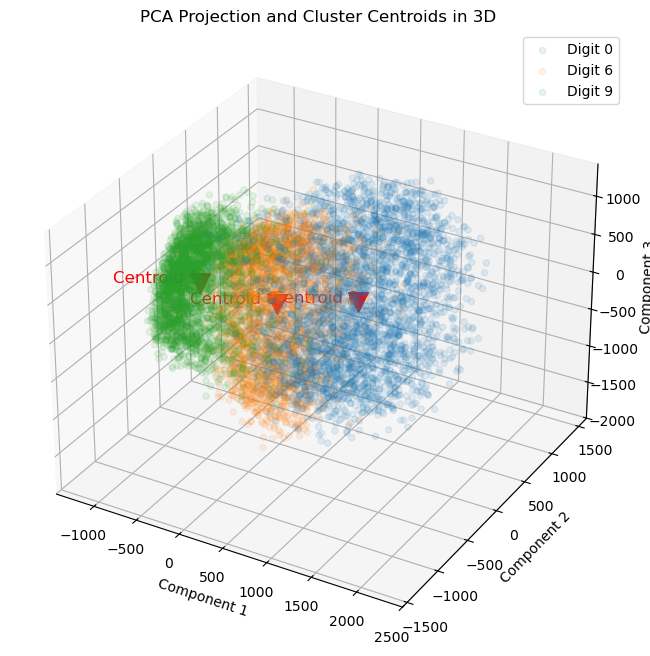

cluster0 coordinate = [894.36570884  33.4528202  188.33506179]
cluster1 coordinate = [-309.772274    400.72443764 -476.74126978]
cluster2 coordinate = [-590.12379066 -432.39826968  285.25964379]
Mean distance from train clusters and its centroid: {0: 468.933, 6: 924.084, 9: 834.708}
Projection of test into the low-dimensional space: (3, 2492)
Mean distance from test clusters and the realtive train centroid: {0: 1104.817, 6: 407.054, 9: 668.844}
Misclassification rate: 0.0658, Accuracy: 0.9342


In [96]:
Z_0_6_9_train_k3, proj_centr_clust_k3, train_coefficients = PCA(X_0_6_9_train, Y_0_6_9_train, labels, d, 3)
Z_0_6_9_train_k3.shape
print("Centroids projections in 3D:")
visualize_3D(Z_0_6_9_train_k3, Y_0_6_9_train, proj_centr_clust_k3)

# Print coordinates of the centroids
for i, coord in enumerate(proj_centr_clust_k3):
    print(f"cluster{i} coordinate = {coord}")

# Compute the average distance of each cluster of X_train from its centroid
distances_train_0_6_9_k3 = average_distance_of_clusters_from_centroid(Z_0_6_9_train_k3, Y_0_6_9_train, proj_centr_clust_k3)
print("Mean distance from train clusters and its centroid:", distances_train_0_6_9_k3)

# Project the test set into the low-dimensional space
Z_0_6_9_test_k3 = project_test_set(X_0_6_9_test, train_coefficients)
print("Projection of test into the low-dimensional space:", Z_0_6_9_test_k3.shape)

# Compute the average distance of each cluster of X_test from the train centroid
distances_test_0_6_9_k3 = average_distance_of_clusters_from_centroid(Z_0_6_9_test_k3, Y_0_6_9_test, proj_centr_clust_k3)
print("Mean distance from test clusters and the realtive train centroid:", distances_test_0_6_9_k3)

# Compute the misclassification rate on the test set
MR_0_6_9_k3,acc_0_6_9_k3 = evaluation_PCA(Z_0_6_9_test_k3, Y_0_6_9_test, proj_centr_clust_k3, labels)
print(f"Misclassification rate: {MR_0_6_9_k3:.4f}, Accuracy: {acc_0_6_9_k3:.4f}")

As can be seen from the outputs we have that by increasing one dimension, so with $K = 3$ all the metrics improve substantially.  
This is also visible from the graph that allows us to notice that the three clusters are much better divided than the previous one.

### Find the best K for the classifier of the three class


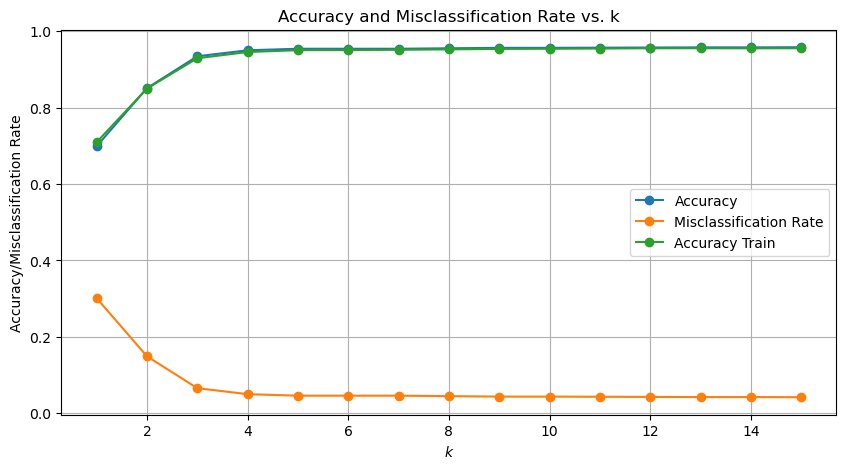

In [100]:
kk = np.arange(1, 16)
accuracy_l = []
accuracy_train = []
mr_l = []
for k in kk:
    Z_0_6_9_train_k, proj_centr_clust_k, train_coefficients_k = PCA(X_0_6_9_train, Y_0_6_9_train, labels, d, k)
    Z_0_6_9_test_k = project_test_set(X_0_6_9_test, train_coefficients_k)
    MR, Acc = evaluation_PCA(Z_0_6_9_test_k, Y_0_6_9_test, proj_centr_clust_k, labels)
    _, Acc_train = evaluation_PCA(Z_0_6_9_train_k, Y_0_6_9_train, proj_centr_clust_k, labels)
    accuracy_l.append(Acc)
    accuracy_train.append(Acc_train)
    mr_l.append(MR)

plt.figure(figsize=(10, 5))
plt.plot(kk, accuracy_l, marker='o', label='Accuracy')
plt.plot(kk, mr_l, marker='o', label='Misclassification Rate')
plt.plot(kk, accuracy_train, marker='o', label='Accuracy Train')
plt.title("Accuracy and Misclassification Rate vs. k")
plt.xlabel(r'$k$')
plt.ylabel("Accuracy/Misclassification Rate")
plt.legend()
plt.grid()
plt.show()


From the graph we can deduce that for our task a projection with $k = 4$ is sufficient, but we can choose a bigger one due to the absence of overfitting since $K = 14$.

Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 13217) (13217,)
Number of samples: 13217
Train test split = 10573, 2644


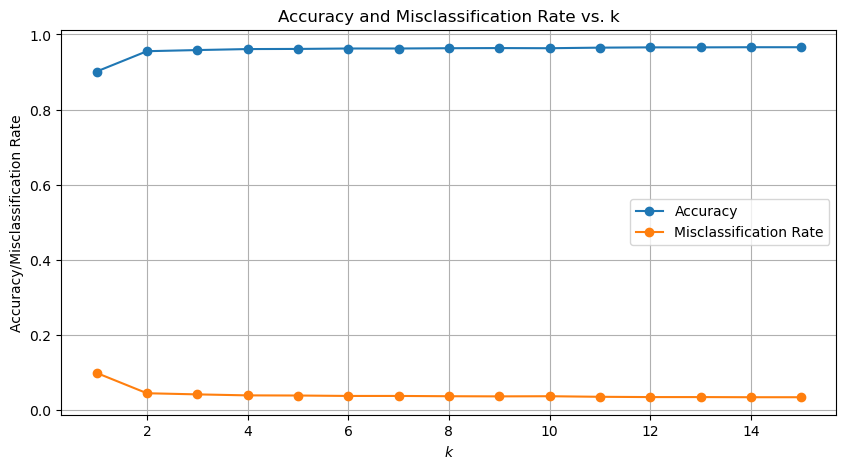

In [90]:
# Extract digits
labels = [0, 1, 7]
X_0_1_7, Y_0_1_7 = filter_dataset(X, Y, labels)
d, N = X_0_1_7.shape
print(f"Number of samples: {N}")
# Train Test split
(X_0_1_7_train, Y_0_1_7_train), (X_0_1_7_test, Y_0_1_7_test) = split_data(X_0_1_7, Y_0_1_7, 0.8 )

kk = np.arange(1, 16)
accuracy_l = []
mr_l = []
for k in kk:
    Z_0_1_7_train_k, proj_centr_clust_k, train_coefficients_k = PCA(X_0_1_7_train, Y_0_1_7_train, labels, d, k)
    Z_0_1_7_test_k = project_test_set(X_0_1_7_test, train_coefficients_k)
    MR, Acc = evaluation_PCA(Z_0_1_7_test_k, Y_0_1_7_test, proj_centr_clust_k, labels)
    accuracy_l.append(Acc)
    mr_l.append(MR)

plt.figure(figsize=(10, 5))
plt.plot(kk, accuracy_l, marker='o', label='Accuracy')
plt.plot(kk, mr_l, marker='o', label='Misclassification Rate')
plt.title("Accuracy and Misclassification Rate vs. k")
plt.xlabel(r'$k$')
plt.ylabel("Accuracy/Misclassification Rate")
plt.legend()
plt.grid()
plt.show()

### Find the best K for the classifier of MNIST

Shape of the original dataset: (784, 42000) (42000,)
Shape of the filtered dataset: (784, 42000) (42000,)
Number of samples: 42000
Train test split = 33600, 8400


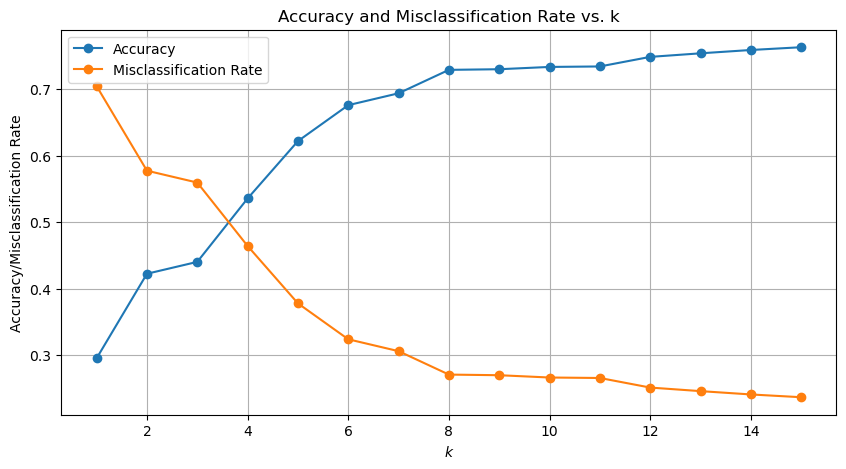

In [91]:
# Extract digits
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
X_all, Y_all = filter_dataset(X, Y, labels)
d, N = X_all.shape
print(f"Number of samples: {N}")
# Train Test split
(X_all_train, Y_all_train), (X_all_test, Y_all_test) = split_data(X_all, Y_all, 0.8 )

kk = np.arange(1, 16)
accuracy_l = []
mr_l = []
for k in kk:
    Z_all_train_k, proj_centr_clust_k, train_coefficients_k = PCA(X_all_train, Y_all_train, labels, d, k)
    Z_all_test_k = project_test_set(X_all_test, train_coefficients_k)
    MR, Acc = evaluation_PCA(Z_all_test_k, Y_all_test, proj_centr_clust_k, labels)
    accuracy_l.append(Acc)
    mr_l.append(MR)

plt.figure(figsize=(10, 5))
plt.plot(kk, accuracy_l, marker='o', label='Accuracy')
plt.plot(kk, mr_l, marker='o', label='Misclassification Rate')
plt.title("Accuracy and Misclassification Rate vs. k")
plt.xlabel(r'$k$')
plt.ylabel("Accuracy/Misclassification Rate")
plt.legend()
plt.grid()
plt.show()


Despite the strong connection between the SVD-based model and PCA, with SVD, classification can be performed directly in the subspaces generated by the $U$ and $V$ matrices. Therefore, SVD does not explicitly account for the variance in the data but instead leverages the direct factorization of the matrix.

In contrast, PCA, in addition to centering the data, focuses on dimensionality reduction by capturing the maximum variance in the centered data. The first components retain most of the variance.

This can be observed from the accuracy of the two models: although PCA performs worse than SVD($acc = 69%$) for small values of $K<7$, once is exceeded, PCA significantly outperforms SVD, despite using relatively less information than standard SVD.